In [ ]:
!pip install tensorflow_privacy

In [ ]:
# importing libraries
import numpy as np
import tensorflow as tf
from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp
from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer

In [ ]:
# setting parameters which are changed for various experiments
dpsgd = False
learning_rate = 0.15
noise_multiplier = 10.0
l2_norm_clip = 1.0
epochs = 10
batch_size = 250
microbatches = batch_size

In [ ]:
def compute_epsilon(steps):
  """Computes epsilon value for given hyperparameters."""
  if noise_multiplier == 0.0:
    return float('inf')
  orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
  sampling_probability = batch_size / 60000
  rdp = compute_rdp(q=sampling_probability,
                    noise_multiplier=noise_multiplier,
                    steps=steps,
                    orders=orders)
  # Delta is set to 1e-5 because MNIST has 60000 training points.
  return get_privacy_spent(orders, rdp, target_delta=1e-5)[0]

In [ ]:
def load_mnist():
  """Loads MNIST and preprocesses to combine training and validation data."""
  train, test = tf.keras.datasets.mnist.load_data()
  train_data, train_labels = train
  test_data, test_labels = test

  train_data = np.array(train_data, dtype=np.float32) / 255
  test_data = np.array(test_data, dtype=np.float32) / 255

  train_data = train_data.reshape((train_data.shape[0], 28, 28, 1))
  test_data = test_data.reshape((test_data.shape[0], 28, 28, 1))

  train_labels = np.array(train_labels, dtype=np.int32)
  test_labels = np.array(test_labels, dtype=np.int32)

  train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)
  test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)

  assert train_data.min() == 0.
  assert train_data.max() == 1.
  assert test_data.min() == 0.
  assert test_data.max() == 1.

  return train_data, train_labels, test_data, test_labels

In [2]:
def create_model():
  # Define a sequential Keras model
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(16, 8,
                             strides=2,
                             padding='same',
                             activation='relu',
                             input_shape=(28, 28, 1)),
      tf.keras.layers.MaxPool2D(2, 1),
      tf.keras.layers.Conv2D(32, 4,
                             strides=2,
                             padding='valid',
                             activation='relu'),
      tf.keras.layers.MaxPool2D(2, 1),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(10)
  ])
  return model

In [ ]:
def main():
  if dpsgd and batch_size % microbatches != 0:
    raise ValueError('Number of microbatches should divide evenly batch_size')

  # Load training and test data.
  train_data, train_labels, test_data, test_labels = load_mnist()

  # Define a sequential Keras model
  model = create_model()

  if dpsgd:
    optimizer = DPKerasSGDOptimizer(
        l2_norm_clip=l2_norm_clip,
        noise_multiplier=noise_multiplier,
        num_microbatches=microbatches,
        learning_rate=learning_rate)
    # Compute vector of per-example loss rather than its mean over a minibatch.
    loss = tf.keras.losses.CategoricalCrossentropy(
        from_logits=True, reduction=tf.losses.Reduction.NONE)
  else:
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

  # Compile model with Keras
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  # Train model with Keras
  history = model.fit(train_data, train_labels,
            epochs=epochs,
            validation_data=(test_data, test_labels),
            batch_size=batch_size)
  # model.save('model_vanilla_sgd')
  np.save('history_vanilla.npy',history.history)

  # Compute the privacy budget expended.
  if dpsgd:
    eps = compute_epsilon(epochs * 60000 // batch_size)
    print('For delta=1e-5, the current epsilon is: %.2f' % eps)
  else:
    print('Trained with vanilla non-private SGD optimizer')

In [ ]:
noise_multiplier = 1.0
eps = compute_epsilon(epochs * 60000 // batch_size)
print('For delta=1e-5, the current epsilon is: %.2f' % eps)

For delta=1e-5, the current epsilon is: 1.34


In [ ]:
if __name__ == '__main__':
  main()

Epoch 1/10
240/240 [==============================] - 2s 8ms/step - loss: 0.6055 - accuracy: 0.8063 - val_loss: 0.1177 - val_accuracy: 0.9624
Epoch 2/10
240/240 [==============================] - 2s 8ms/step - loss: 0.1172 - accuracy: 0.9630 - val_loss: 0.0759 - val_accuracy: 0.9760
Epoch 3/10
240/240 [==============================] - 2s 7ms/step - loss: 0.0834 - accuracy: 0.9740 - val_loss: 0.0571 - val_accuracy: 0.9819
Epoch 4/10
240/240 [==============================] - 2s 7ms/step - loss: 0.0757 - accuracy: 0.9765 - val_loss: 0.0497 - val_accuracy: 0.9847
Epoch 5/10
240/240 [==============================] - 2s 7ms/step - loss: 0.0566 - accuracy: 0.9824 - val_loss: 0.0458 - val_accuracy: 0.9859
Epoch 6/10
240/240 [==============================] - 2s 7ms/step - loss: 0.0480 - accuracy: 0.9848 - val_loss: 0.0432 - val_accuracy: 0.9860
Epoch 7/10
240/240 [==============================] - 2s 7ms/step - loss: 0.0439 - accuracy: 0.9868 - val_loss: 0.0368 - val_accuracy: 0.9891
Epoch 

In [ ]:
history_vanilla = np.load('/content/history_vanilla.npy',allow_pickle='TRUE').item()
history_0 = np.load('/content/history_0.1.npy',allow_pickle='TRUE').item()
history_1 = np.load('/content/history_1.npy',allow_pickle='TRUE').item()
history_10 = np.load('/content/history_10.npy',allow_pickle='TRUE').item()

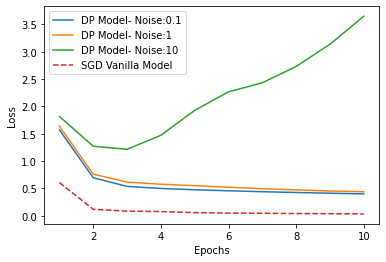

In [ ]:
import matplotlib.pyplot as plt
  
# create data
x = np.linspace(1, 10, 10)
  
# plot lines
fig = plt.figure()
plt.plot(x, history_0["loss"], label = "DP Model- Noise:0.1")
plt.plot(x, history_1["loss"], label = "DP Model- Noise:1")
plt.plot(x, history_10["loss"], label = "DP Model- Noise:10")
plt.plot(x, history_vanilla["loss"], label = "SGD Vanilla Model", linestyle = "--")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

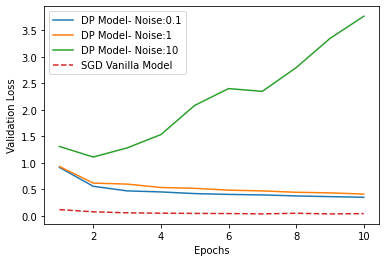

In [ ]:
import matplotlib.pyplot as plt
  
# create data
x = np.linspace(1, 10, 10)
  
# plot lines
fig = plt.figure()
plt.plot(x, history_0["val_loss"], label = "DP Model- Noise:0.1")
plt.plot(x, history_1["val_loss"], label = "DP Model- Noise:1")
plt.plot(x, history_10["val_loss"], label = "DP Model- Noise:10")
plt.plot(x, history_vanilla["val_loss"], label = "SGD Vanilla Model", linestyle = "--")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

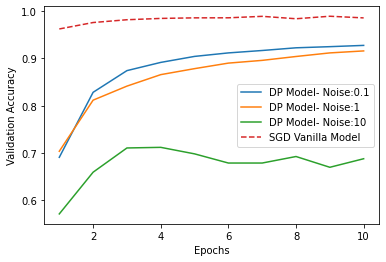

In [ ]:
import matplotlib.pyplot as plt
  
# create data
x = np.linspace(1, 10, 10)
  
# plot lines
fig = plt.figure()
plt.plot(x, history_0["val_accuracy"], label = "DP Model- Noise:0.1")
plt.plot(x, history_1["val_accuracy"], label = "DP Model- Noise:1")
plt.plot(x, history_10["val_accuracy"], label = "DP Model- Noise:10")
plt.plot(x, history_vanilla["val_accuracy"], label = "SGD Vanilla Model", linestyle = "--")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()

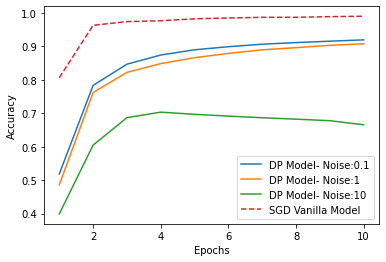

In [ ]:
import matplotlib.pyplot as plt
  
# create data
x = np.linspace(1, 10, 10)
  
# plot lines
fig = plt.figure()
plt.plot(x, history_0["accuracy"], label = "DP Model- Noise:0.1")
plt.plot(x, history_1["accuracy"], label = "DP Model- Noise:1")
plt.plot(x, history_10["accuracy"], label = "DP Model- Noise:10")
plt.plot(x, history_vanilla["accuracy"], label = "SGD Vanilla Model", linestyle = "--")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()